# Assignment 9: Final Project
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020


# Objectives

Upon completion of this assignment, students will have:

1. Described the list generation process in detail
2. Described the experiment details
3. Visualized processed data
4. Performed a statistical analysis to test the hypothesis

# Assignment

Write text (in MarkDown cells) and code (in Code cells) in a Jupyter notebook (after making a copy and renaming it to have your userid in the title --- e.g., A09_Final_Project_mst3k).


## Details

The goal of the final project is to synthesize material covered in the class and produce part of what would go into an actual scientific publication based on *one* of the experiments we ran in the class. Specifically, you will be writing part of the Methods and Results sections.

The basic template is below the code for loading and processing the data. There we outline what each section should include. As always, make sure to label all figures and be sure to refer to the code in the lesson notebooks as a guide for your analyses.

Please feel free to reach out to us on Slack if you have any questions along the way.

* ***When you are done, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on UVACollab.***  

## General Imports

In [74]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn 
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os
import statsmodels.formula.api as smf

from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [75]:
# custom function to load slogs
def load_all_subj_logs(task_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.split(subj_dir)[-1] 
             for subj_dir in glob(os.path.join(task_dir, 's*'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(task_dir, subj, log_file)
        #print(log_path)

        # load the data
        all_dat.extend(log2dl(log_path, subj=subj))

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [76]:
# load the data from the word recog task
task_dir = os.path.join('..', 'lessons', 'all_data', 'data', 'Taskapalooza')

df_f = load_all_subj_logs(task_dir, 'log_flanker')
df_i = load_all_subj_logs(task_dir, 'log_image_test')
df_w = load_all_subj_logs(task_dir, 'log_word_test')
df_i.head()

,resp_map_lure,resp_map_target,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,correct,log_time,filename,in_out,novelty,cond,subj,log_num
0,F,J,0,0,2361.470167,0.0,F,2362.502265,0.000391,1.032098,True,2363.385215,out2646.jpg,outdoor,lure,outdoor,s001,0
1,F,J,0,1,2363.392059,0.0,J,2363.993073,0.001033,0.601014,True,2364.559602,out0031_new.jpg,outdoor,target,outdoor,s001,0
2,F,J,0,2,2364.572868,0.0,F,2365.363671,0.000197,0.790803,True,2365.870152,out1227.jpg,outdoor,lure,outdoor,s001,0
3,F,J,0,3,2365.874493,0.0,F,2366.714544,0.000191,0.840051,True,2367.588254,out0134_new.jpg,outdoor,lure,outdoor,s001,0
4,F,J,0,4,2367.592558,0.0,F,2368.463209,0.000248,0.870651,True,2369.152451,out2086.jpg,outdoor,lure,outdoor,s001,0


## Some data clean-up

In [77]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    # loop over the unique subjects
    usubj = df.subj.unique()
    for s in usubj:
        # loop over their blocks
        ublocks = df.loc[df['subj']==s, 'block_num'].unique()
        for b in ublocks:
            # grab the data for that subj and block
            dfb = df.loc[(df['subj']==s)&(df['block_num']==b)]
            
            # get the unique types in that block
            uval = dfb[type_col].unique()
            if len(uval) > 1:
                # it's mixed
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'mixed'
            else:
                # it's the pure
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_i, type_col='in_out')
fix_conds(df_w, type_col='valence')

# add in log_rt columns
df_f['log_rt'] = np.log(df_f['rt'])
df_i['log_rt'] = np.log(df_i['rt'])
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_f['correct'] = df_f['correct'].astype(np.int)
df_i['correct'] = df_i['correct'].astype(np.int)
df_w['correct'] = df_w['correct'].astype(np.int)

# add in a column for whether they made an 'old' response
df_i['old_resp'] = (df_i['resp_map_target'] == df_i['resp']).astype(np.int)
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(np.int)

# process some of the valence info
df_w['valence_mean'] = df_w['valence_mean'].astype(np.float)
df_w['arousal_mean'] = df_w['arousal_mean'].astype(np.float)
df_w['dominance_mean'] = df_w['dominance_mean'].astype(np.float)
df_w['abs_valence'] = np.abs(df_w['valence_mean'] - 5.0)
df_w['abs_arousal'] = np.abs(df_w['arousal_mean'] - 5.0)

# Your text and code goes below here

*All code above should work without modification.*

# Hypothesis

*I believe that the response time in the indoor/outdoor test will decrease as the trials go on, but will eventually start increasing after it's peak as a result of weariness.*

# Methods

*This section should read like a methods section of a journal article. Fill in the two sub-sections below.*

## List generation

*Provide enough detail (in words) about the list generation so that someone could recreate the list generation code themselves. Be sure to state all the specific parameters used, including number of stimuli per block and number of blocks. Refer to the list generation code we provided to find all the information you need.*

#### Block Generation
*To begin, there needs to be a method to handle creating the blocks. This includes the pure trial blocks for the Indoor and Outdoor pictures or the Positive, Negative, and Neutral words, as well as the mixed trials which include words or pictures from each group.*

*To do this, the method will have to read in three arguments:*
*1) The pools of words or pictures*
*2) The cond(condition), so whether it's one of the "pure" or "mixed" trials*
*3) The num_items(number of items) to specify how many words or pictures you want to appear*

*You will also need to add some dicts to the list. One to specify is the novelty is a target or a lure and one to specify the condition of the test. Each study trial will start with only targets. These are the things that the subject needs to memorize. At the test trial, there needs to be an equal number of lures added to the list of items.*

*Finally, the particular experiment needs to be decided. Regardless of whether the image or word experiment is chosen, the different pool files need to be read in. After that, go through and make sure that both pure and mixed trials can be produced. If the image test is chosen, this means that there needs to be tests with just indoor and just outdoor pictures as well as a test with both. If the word test is chosen, there needs to be a test for just negative words, just positive words, and just neutral words, as well as all types of words. On top of that, the list of items needs to be randomized at each iteration. This means that each time a trial is run, there should be different items in different order. Finally, no two trials should share any of the same items, so make sure that the words or images or removed once the trial is over.*

## SMILE Experiment Details

*Provide enough detail so that someone could implement the experiment presentation and response collection, including all timing information and how the blocks were structured and presented.*

*For the image experiment, the subject will need two different buttons to press. One will be for if the image that pops up is a target (was in the original list) or is a lure (was just added to the list). They may be whatever key you choose, but they should preferably not be directly next to each other to avoid any confusion. These keys will also need to be used for a math section that will fall in the middle of each block in which one key will need to be pressed if an equation given is true and the other for if the equation given is false.*

*To start, there needs to be an opening page explaining the experiment, along with the math compnent. Pressing any key should send them to the next screen asking if they're ready to begin. At the end of each trial and block as well as after each math component, the subject should be given a screen they can stay at until ready (which is shown by pressing any key) so they may have a break.* 

*There is also timing that needs to be accounted for. During the study trials the subject should have 1.5 seconds to study each image before it disappears. Also include 0.5 seconds of a space between each image as well as 0.5 seconds of jitter. Once they are done with the study trial, they are to be taken to the math section which will display an equation with an answer attached. They are to determine if the equation and matching answer are true or not. They will have 20 seconds to answer as many of these as possible. Once the math component is over, they should then be prompted to begin the test trial portion where they must identify the images from the original list and images just added. At the end of this, they should be given another break with a prompt allowing them to continue on to the next block.*

*Once they have completed the number of blocks specified, there should be a screen to congratulate them on finishing.*

# Results

*In this section, state a specific question, then define your dependent and independent variables that will help you answer that question. As stated above, your question must give rise to an analysis that is not identical to one we performed in class (i.e., you must do more than copy and paste code with zero changes. That said, the analysis can match those from the class quite closely.*

## Data processing and visualization

*With the lessons as a guide, process your data to create the necessary data frame to plot the visualization associated with the question stated above. Then plot those data.*

In [90]:
# Code for data processing and visualization
from ci_within import ci_within
# get the error corrected by condition and whether they got it correct
res = ci_within(df_i,  
                indexvar='subj',
                withinvars=['block_num'],
                measvar='log_rt').reset_index()
res

,block_num,mean,std,sem,ci,len
0,0,-0.140220,0.340891,0.010260,0.020131,1104.0
1,1,-0.151749,0.346145,0.010418,0.020441,1104.0
2,2,-0.197151,0.305164,0.009184,0.018021,1104.0
3,3,-0.156798,0.330135,0.009936,0.019495,1104.0
4,4,-0.193311,0.327506,0.009857,0.019340,1104.0
5,5,-0.181104,0.326410,0.009824,0.019275,1104.0
6,6,-0.189676,0.342185,0.010299,0.020207,1104.0
7,7,-0.167975,0.355410,0.010697,0.020988,1104.0
8,8,-0.200167,0.339031,0.010204,0.020021,1104.0


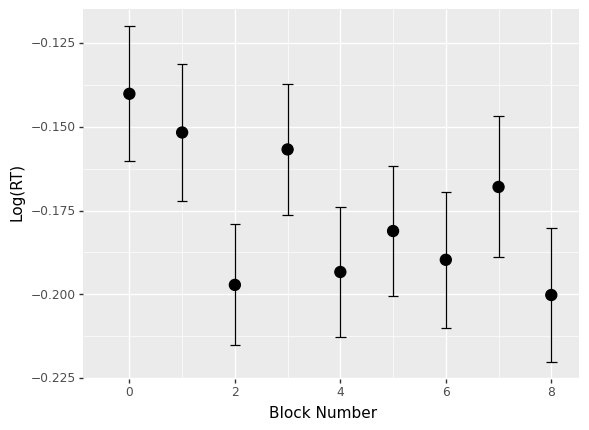

<ggplot: (143351058646)>

In [91]:
p = (pn.ggplot(res, pn.aes('block_num', 'mean'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
#      + pn.facet_wrap('~novelty')
     + pn.labs(x="Block Number", y = "Log(RT)", fill='Location')
    )
p

*In order to determine if the total elapsed time(block number) had any bearing on the subjects response time, I chose to compare the change in the natural log of the response time(Log(RT)) as well as include any amount of error that may have shown up in the calculations.*

*At a cursory glance, the graph seems to project in a negative slope, which would suggest that the average subject improved their response time over the course of the trials. However, with the inclusion of the error bars, it can be seen that there is an incredibly significant overlap between the different blocks. This, instead, says that the particular block number has no effect on the response time of the average subject.*

*If this holds up in the statistical analysis, this would refute the entirety of my hypothesis.*

## Statistical test and interpretation

*Perform a statistical test to support your conclusions with regard to your question outlined above. This can be with either statsmodels or with bambi.*

In [55]:
# Code for statistical test (can be either with statsmodels or bambi)
sum_df = df_i.groupby(['subj', 'block_num'])['log_rt'].mean().reset_index()
sum_df

,subj,block_num,log_rt
0,s001,0,-0.238171
1,s001,1,-0.278590
2,s001,2,-0.294667
3,s001,3,-0.343568
4,s001,4,-0.407093
...,...,...,...
202,s023,4,-0.282568
203,s023,5,-0.277165
204,s023,6,-0.274065
205,s023,7,-0.313506


In [56]:
model = smf.ols("log_rt ~ block_num", sum_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.457
Date:                Tue, 08 Dec 2020   Prob (F-statistic):              0.229
Time:                        09:58:17   Log-Likelihood:                 96.179
No. Observations:                 207   AIC:                            -188.4
Df Residuals:                     205   BIC:                            -181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1555      0.020     -7.941      0.000      -0.194      -0.117
block_num     -0.0050      0.004     -1.207      0.229      -0.013       0.003
==============================================================================
Omnibus:                        6.252   Durbin-Watson:                   0.693
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.323
Skew:                           0.399   Prob(JB):                       0.0424
Kurtosis:                       2.690   Cond. No.                         9.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*Upon entering in the information for the block numbers and log(rt), the most important statistic would be the p-value(P>|t|). To determine whether a factor has any statistical significance in an experiment, a confidence interval of 5% is usually set. In some cases, a confidence interval of 10% is set. Looking to the p-value, however, we see 0.229(22.9%), which falls incredibly far outside of the confidence interval.*

*Combining what has been shown in the graph previously, along with the statistical analysis above, it can be concluded that the hypothesis I had made at the beginning of the experiment is entirely refuted. There is no statistical evidence whatsoever to suggest that the number of a particular block in the image test has any bearing on the subjects average response time.*

*Perhaps, as a follow-up, it could be checked whether the box number had any sort of effect on the number of correct responses instead seeing as weariness could have a larger effect on memory.*

# Discussion

***Graduate students only!!!***

*In one to two paragraphs do the following: a) Place the study in the larger literature, summarizing some of the similar work in the field and how this study compares, b) write some analysis of the findings from the study (even if they are null results) and then describe a follow-up study with a new variant of the experiment that you think might help answer further questions on the topic.